# TV signal decoding

In [148]:
import math
import os

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy.signal
import PIL.Image

%matplotlib inline

In [149]:
# Load signal
with np.load("./tv-signal.npz") as f:
    input_sample_rate = f["sample_rate"]
    input_frame_signal = f["signal"]
    input_filename = f["input_filename"].tobytes().decode("utf32")
print(f"Loaded {input_frame_signal.shape[0]} samples at a sample rate of {input_sample_rate}MHz.")

# Add noise. We do this before the low-pass filter to ensure the noise is also
# band-limited.
noise_amplitude = 0 # IRE
input_frame_signal += np.random.normal(scale=noise_amplitude, size=input_frame_signal.shape)

# Simulate a bandwidth limit with a Butterworth low-pass filter.
bandwidth = 6 # MHz
sos = scipy.signal.butter(10, bandwidth, analog=False, btype="low", fs=input_sample_rate, output="sos")
filtered_input_frame_signal = scipy.signal.sosfilt(sos, input_frame_signal)

# We will resample the signal when processing to make sure we've not got anything left
# over which is a multiple of the sample rate we created the signal at.
sample_rate = 0.66 * input_sample_rate # Mhz

# The time of each resampled sample
n_frame_samples = int(math.floor(sample_rate * filtered_input_frame_signal.shape[0] / input_sample_rate))
frame_signal_times = np.arange(n_frame_samples) / sample_rate
interpolate_input = scipy.interpolate.interp1d(
    x=np.arange(filtered_input_frame_signal.shape[0]) / input_sample_rate,
    y=filtered_input_frame_signal,
    bounds_error=False, fill_value=0,
)
frame_signal = interpolate_input(frame_signal_times)

Loaded 1068900 samples at a sample rate of 32.0MHz.


In [150]:
# Not critical but we use this in some of the filter designs.
line_time = 63.6 # µs
back_porch_time = 6.2 # µs
front_porch_time = 1.5 # µs
h_sync_time = 4.7 # µs

# Levels taken from https://www.eetimes.com/wp-content/uploads/media-1050359-c0195-figure1.gif
# Measures in "IRE" (https://en.wikipedia.org/wiki/IRE_(unit))
black_level = 0.0
white_level = 100.0
sync_level = -40.0

# For NTSC "the horizontal scanning frequency shall be 2/455 times the color subcarrier
# frequency" (https://antiqueradio.org/art/NTSC%20Signal%20Specifications.pdf)
colour_subcarrier_frequency = 455 / (2 * line_time) # MHz

# Colour information
colour_carrier_amplitude = 0.5 * sync_level
colour_burst_start_time = h_sync_time + 1.1 # µs
colour_burst_time = 8 / colour_subcarrier_frequency # µs, derived from no. of cycles

# Total number of scan lines in an entire frame along with the number of active lines.
frame_total_lines = 525
frame_active_lines = 480

# Total number of pixels to reconstruct for each line
h_pixel_count = 640

In [151]:
# Compute chroma bandpass filter based on the nominal colour burst frequency.
bp_quality = 1
colourbust_bp_ba = scipy.signal.iirpeak(colour_subcarrier_frequency, bp_quality, sample_rate)

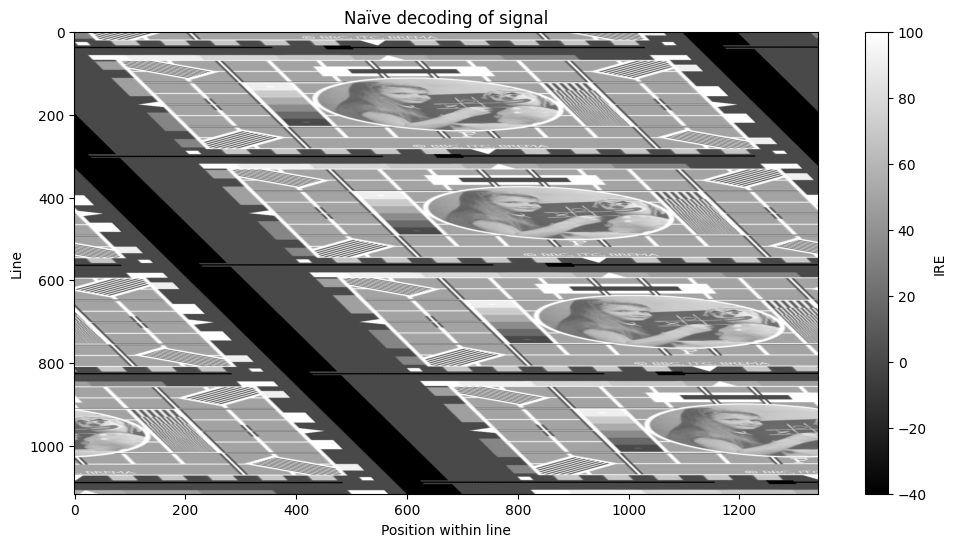

In [152]:
# Construct a signal with at least one full frame and some partial frames.
video_signal = np.concatenate((
    frame_signal[-frame_signal.shape[0]>>4:],
    frame_signal, frame_signal,
    frame_signal[:frame_signal.shape[0]>>4]
))
video_signal_times = np.arange(video_signal.shape[0]) / sample_rate

# Show a naïve decoding based entirely on expected line time. We should
# see all manner of sync problems.
line_samples = math.floor(line_time * sample_rate)
n_lines = math.floor(video_signal.shape[0] / line_samples)
naive_decode = video_signal[:n_lines*line_samples].reshape((-1, line_samples))

plt.figure(figsize=(12, 6))
plt.imshow(naive_decode, clim=(sync_level, white_level), cmap=plt.cm.gray, aspect="auto")
plt.title("Naïve decoding of signal")
plt.xlabel("Position within line")
plt.ylabel("Line")
plt.colorbar().set_label("IRE")
plt.show()

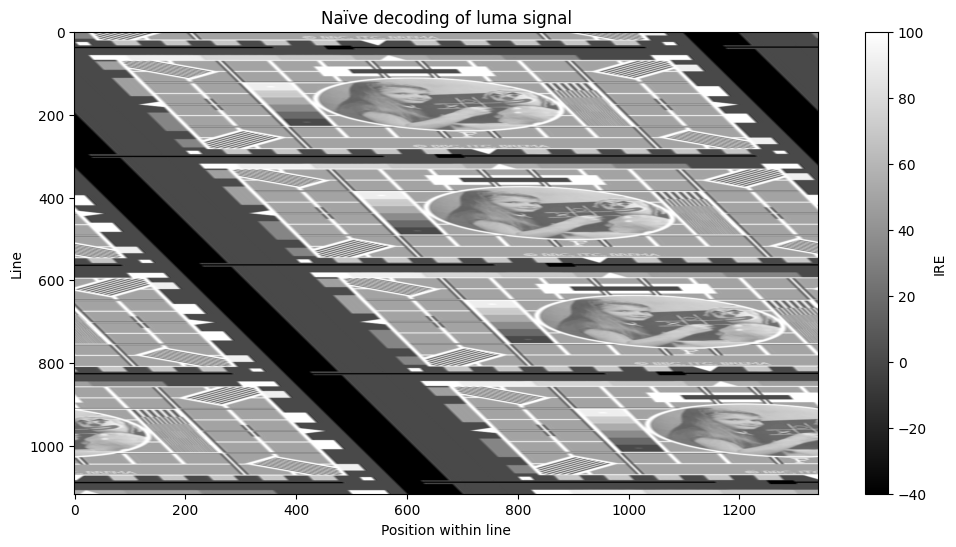

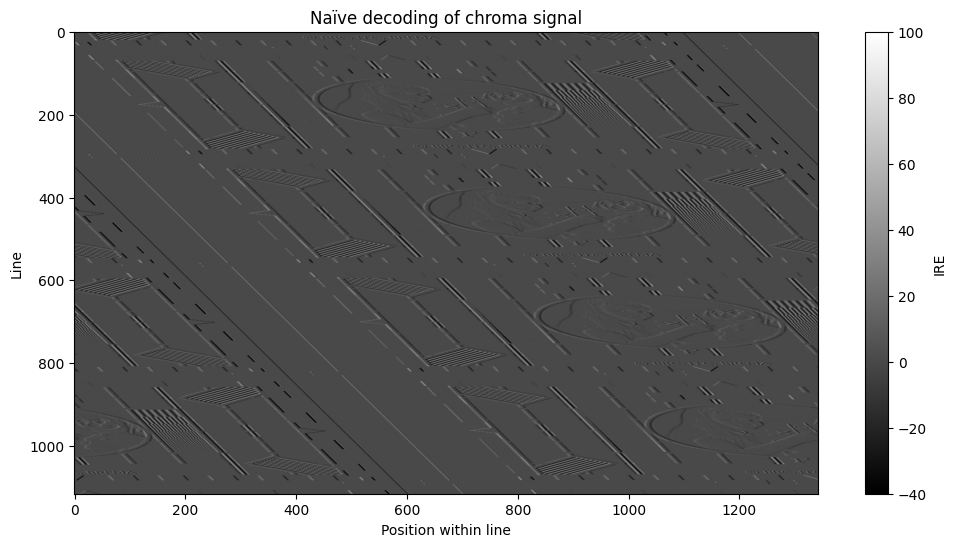

In [153]:
# Extract luminance and chroma video signals via bandpass filter
video_chroma_signal = scipy.signal.lfilter(*colourbust_bp_ba, x=video_signal)
video_luma_signal = video_signal - video_chroma_signal

naive_decode = video_luma_signal[:n_lines*line_samples].reshape((-1, line_samples))
plt.figure(figsize=(12, 6))
plt.imshow(naive_decode, clim=(sync_level, white_level), cmap=plt.cm.gray, aspect="auto")
plt.title("Naïve decoding of luma signal")
plt.xlabel("Position within line")
plt.ylabel("Line")
plt.colorbar().set_label("IRE")
plt.show()

naive_decode = video_chroma_signal[:n_lines*line_samples].reshape((-1, line_samples))
plt.figure(figsize=(12, 6))
plt.imshow(naive_decode, clim=(sync_level, white_level), cmap=plt.cm.gray, aspect="auto")
plt.title("Naïve decoding of chroma signal")
plt.xlabel("Position within line")
plt.ylabel("Line")
plt.colorbar().set_label("IRE")
plt.show()

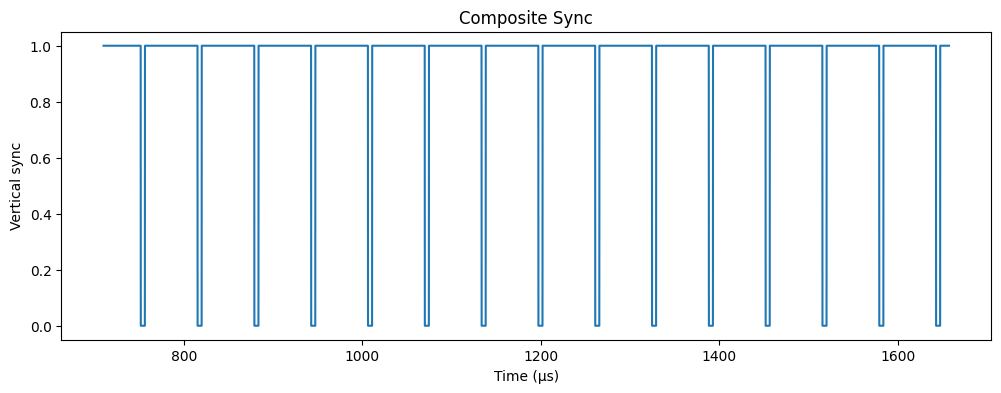

In [154]:
# Implement sync separator from https://www.ntsc-tv.com/images/tv/sync-sp.gif
clip_level = -25

# The first comparator determines if the signal is above or below the clip level
# to regenerate a composite sync pulse.
composite_sync = np.where(video_luma_signal >= clip_level, 1, 0)

def show_signal(signal, title, *, subset=slice(None, None)):
    plt.figure(figsize=(12, 4))
    plt.plot(video_signal_times[subset], signal[subset])
    plt.title(title)
    plt.xlabel("Time (µs)")
    plt.ylabel("Vertical sync")
    plt.show()

show_signal(composite_sync, "Composite Sync", subset=slice(15000, 35000))

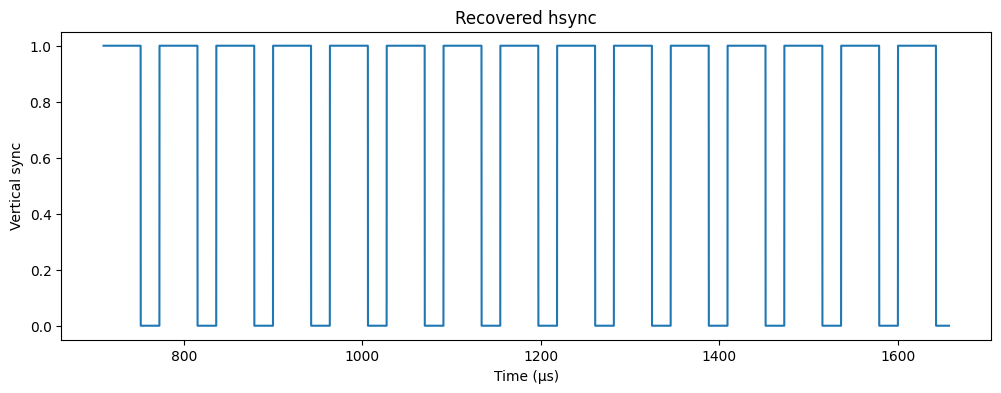

In [155]:
# The horizontal sync is recovered by triggering on low-going pulses from the
# composite sync but not re-triggering for some hold time. (In the sync separator
# circuit this is done by having the reset line for the one-shot trigger driven
# by an RC-filter.) Implementing this efficiently in numpy is a little tricky.

# Compute indices of low-going edges from composite sync.
cs_low_going_edge_indices = np.logical_and(composite_sync[:-1] > 0.5, composite_sync[1:] <= 0.5).nonzero()[0]

# Now many samples in the future must the next low-going edge be? We make this
# most of a line.
min_sample_separation = 0.8 * line_time * sample_rate

# How long is a sync pulse in samples? We make it 1/3 of a line to aid with
# odd/even detection.
h_sync_samples = int(math.ceil(0.33 * line_time * sample_rate))

# Recovered hsync starts as all ones
h_sync = np.ones_like(video_signal)

# Walk edges adding in sync pulses.
last_good_edge_idx = None
for edge_idx in cs_low_going_edge_indices:
    if last_good_edge_idx is None or (edge_idx - last_good_edge_idx) >= min_sample_separation:
        last_good_edge_idx = edge_idx
        h_sync[edge_idx:edge_idx+h_sync_samples] = 0
        
# Find -ve going edges
h_sync_edge_indices = np.logical_and(h_sync[:-1] > 0.5, h_sync[1:] <= 0.5).nonzero()[0] + 1

show_signal(h_sync, "Recovered hsync", subset=slice(15000, 35000))

Recovering v-sync with lowpass cutoff of 10.64kHz


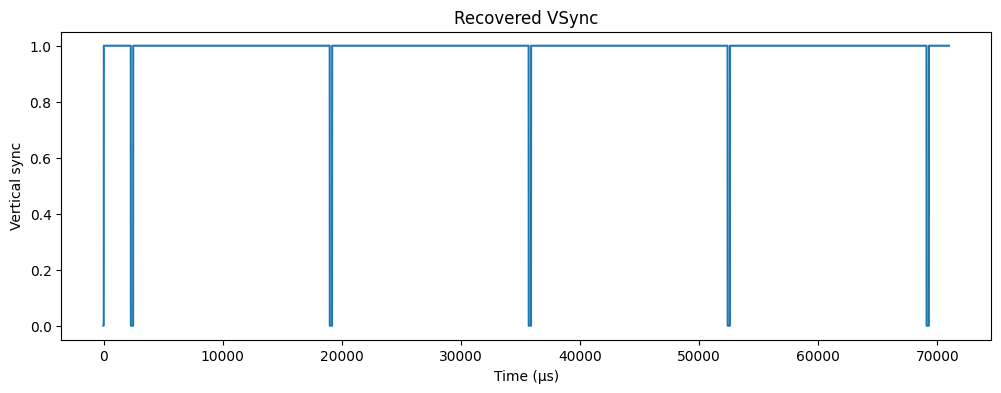

In [156]:
# We restore the vertical sync by low-pass filtering the composite sync.
# We need a -3dB frequency which is above the line frequency (so we
# retrive the vsync pulse) but which is well below the frequency implied by
# the hsync pulse length.

# The frequency implied by the h-sync pulse. (I.e. a period of two
# times the pulse width.)
h_sync_implied_frequency = 1 / (2 * h_sync_time)

# Choose a cutoff frequency well below the implied pulse frequence.
cutoff_frequency = 0.1 * h_sync_implied_frequency
print(f"Recovering v-sync with lowpass cutoff of {1000 * cutoff_frequency:.2f}kHz")

# A simple first order Butterworth filter. Some TVs just use an passive RC filter for this
# and so we don't need to be too clever.
sos = scipy.signal.butter(1, cutoff_frequency, analog=False, btype="low", fs=sample_rate, output="sos")
lowpass_signal = scipy.signal.sosfilt(sos, composite_sync)

# Compute VSync via comparator.
v_sync = np.where(lowpass_signal < 0.66, 0, 1)
show_signal(v_sync, "Recovered VSync")

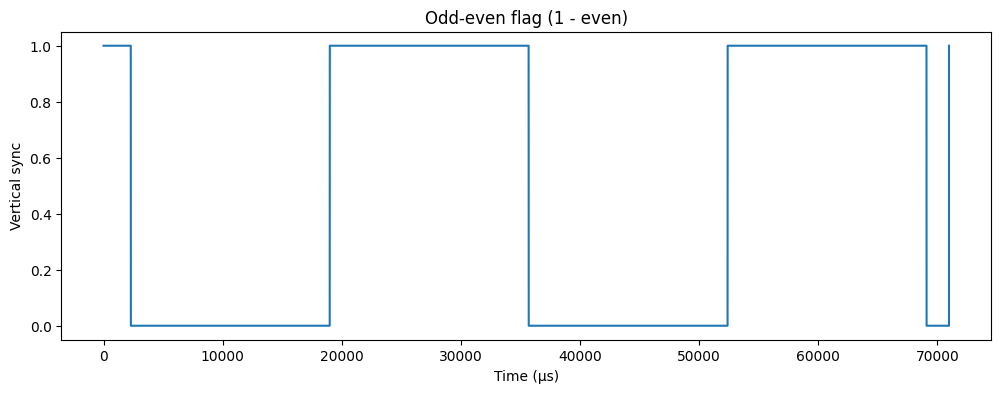

In [157]:
# The odd-even flag is computed with a D-type flip flop. We model that with
# first order hold
v_sync_edge_indices = np.logical_and(v_sync[:-1] > 0.5, v_sync[1:] <= 0.5).nonzero()[0] + 1
oe_sample_indices = np.concatenate(([0], v_sync_edge_indices, [video_signal_times.shape[0]-1]))
odd_even_sample_times = video_signal_times[oe_sample_indices]
odd_even_generator = scipy.interpolate.interp1d(
    x=odd_even_sample_times,
    y=h_sync[oe_sample_indices],
    kind="previous", bounds_error=False, fill_value="extrapolate",
)
odd_even_flag = odd_even_generator(video_signal_times)

show_signal(odd_even_flag, "Odd-even flag (1 - even)")

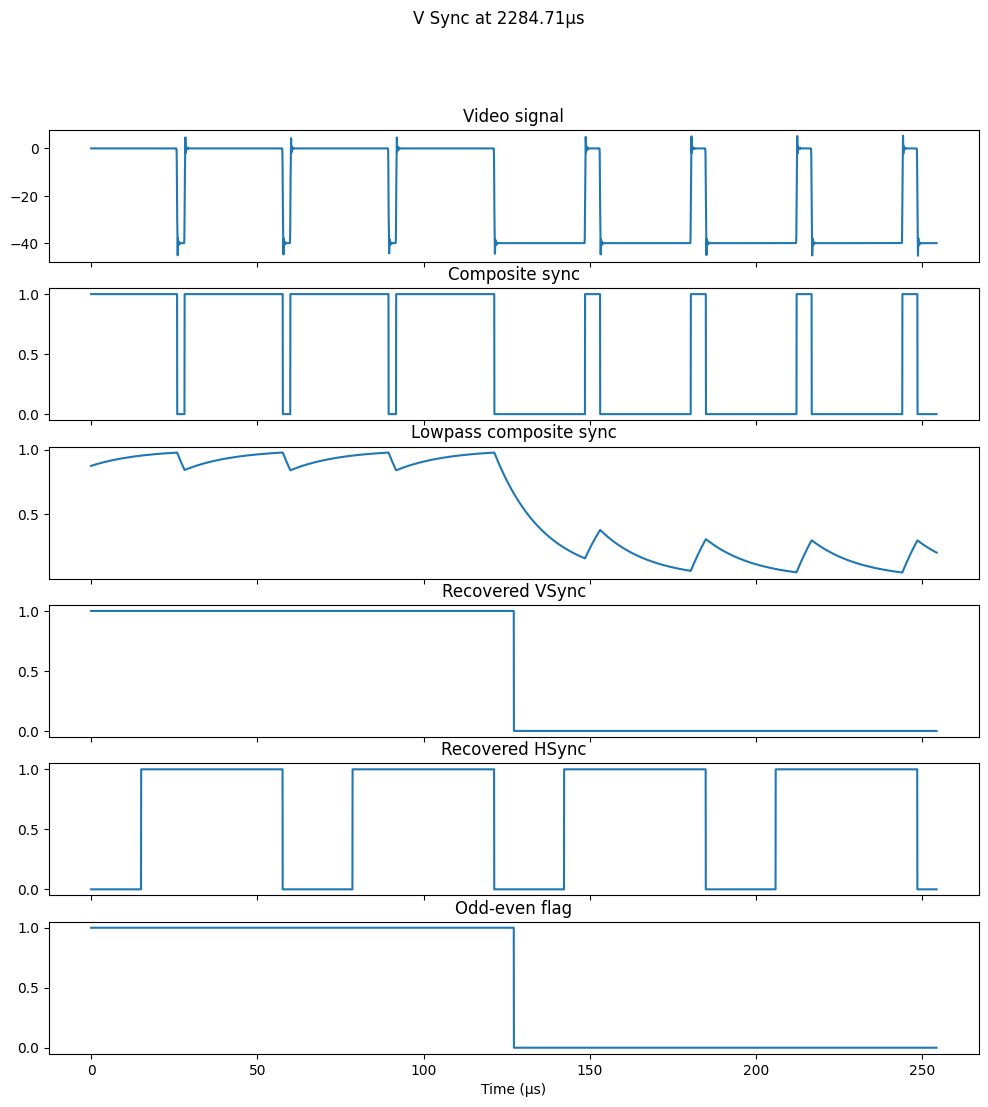

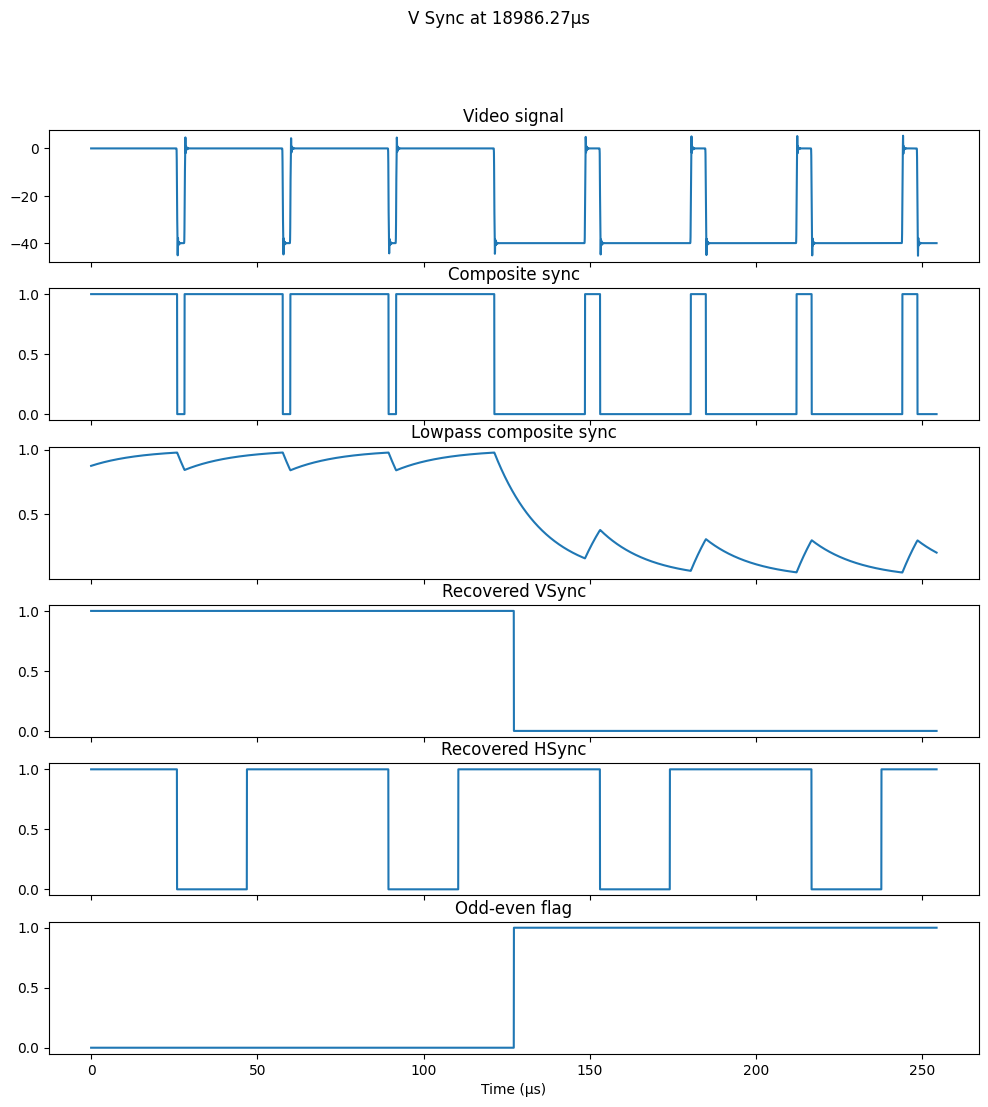

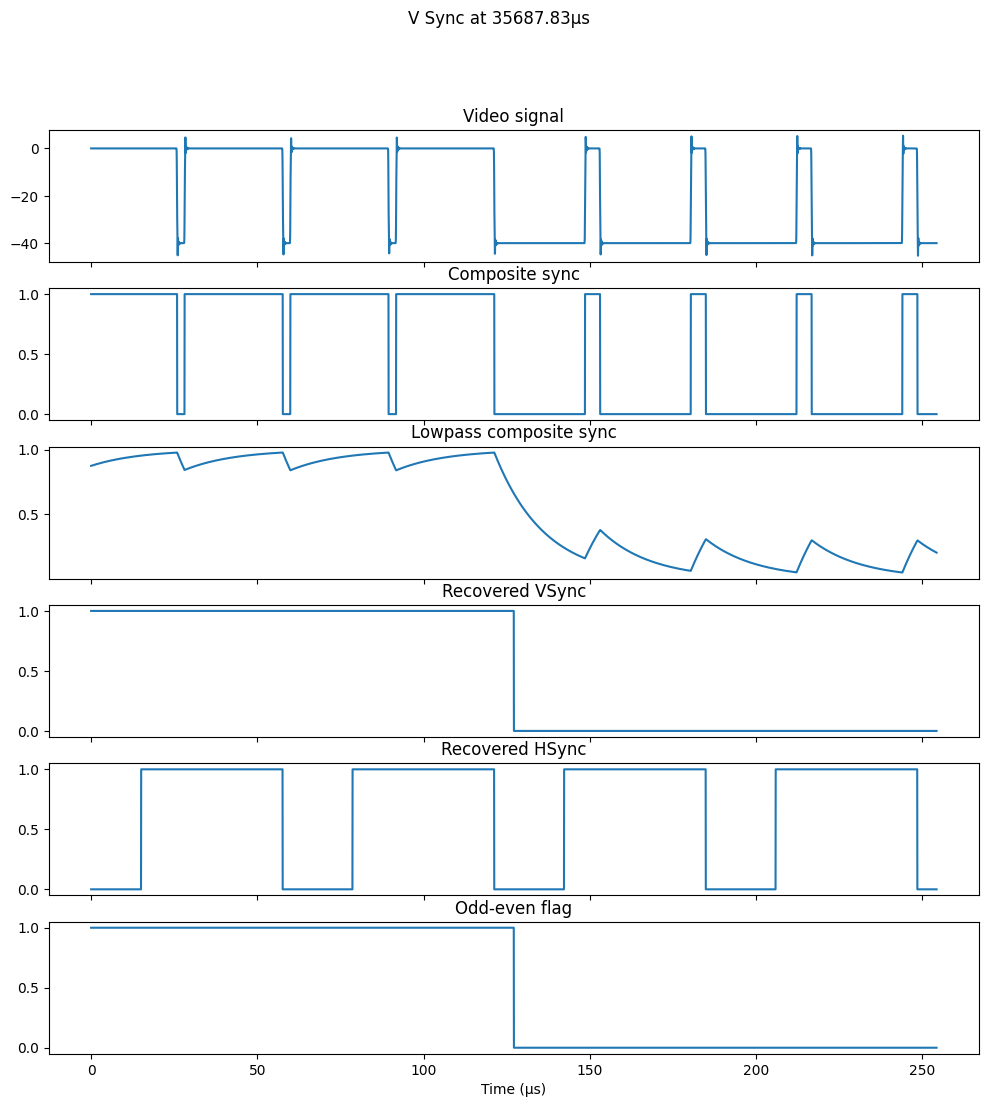

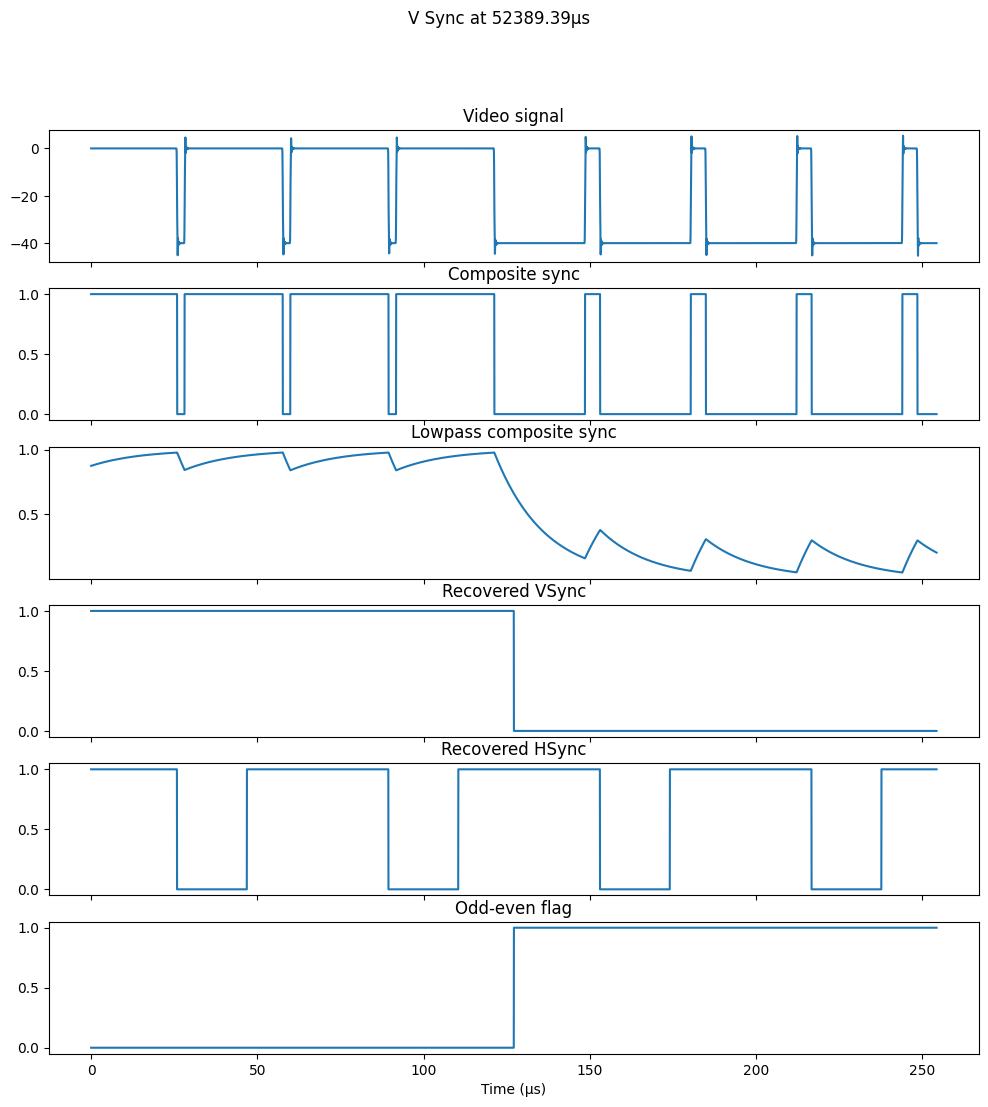

In [158]:
deltas = int(2 * line_time * sample_rate), int(2 * line_time * sample_rate)
for edge_idx in v_sync_edge_indices[:4]:
    s, e = edge_idx-deltas[0], edge_idx+deltas[1]
    st = video_signal_times[s]
    
    f, axs = plt.subplots(6, 1, figsize=(12, 12), sharex=True)
    f.suptitle(f"V Sync at {edge_idx / sample_rate:.2f}µs") 
    axs[0].plot(video_signal_times[s:e] - st, video_luma_signal[s:e])
    axs[0].set_title("Video signal")
    axs[1].plot(video_signal_times[s:e] - st, composite_sync[s:e])
    axs[1].set_title("Composite sync")
    axs[2].plot(video_signal_times[s:e] - st, lowpass_signal[s:e])
    axs[2].set_title("Lowpass composite sync")
    axs[3].plot(video_signal_times[s:e] - st, v_sync[s:e])
    axs[3].set_title("Recovered VSync")
    axs[4].plot(video_signal_times[s:e] - st, h_sync[s:e])
    axs[4].set_title("Recovered HSync")
    axs[5].plot(video_signal_times[s:e] - st, odd_even_flag[s:e])
    axs[5].set_title("Odd-even flag")
    axs[-1].set_xlabel("Time (µs)")

In [159]:
# Find start of first full frame. This is the v_sync edge corresponding to the first
# even field.
frame_start_vsync = (odd_even_flag[v_sync_edge_indices] > 0.5).nonzero()[0][0]
even_field_v_sync_idx = v_sync_edge_indices[frame_start_vsync]
print(f"Found even field vsync at {even_field_v_sync_idx / sample_rate:.2f}µs")
print(f"Vsync is index {frame_start_vsync}")

# Find the hsync start indices for the next complete frame. Note that this starts from the line after
# the one containing the vsync pulse which is from line 5 using 1-based indexing. This means we're missing
# the first 4 lines. We'll put them back in when we decode the frame later on.
line_start_indices = h_sync_edge_indices[h_sync_edge_indices > even_field_v_sync_idx][:frame_total_lines-4]

Found even field vsync at 18986.27µs
Vsync is index 1


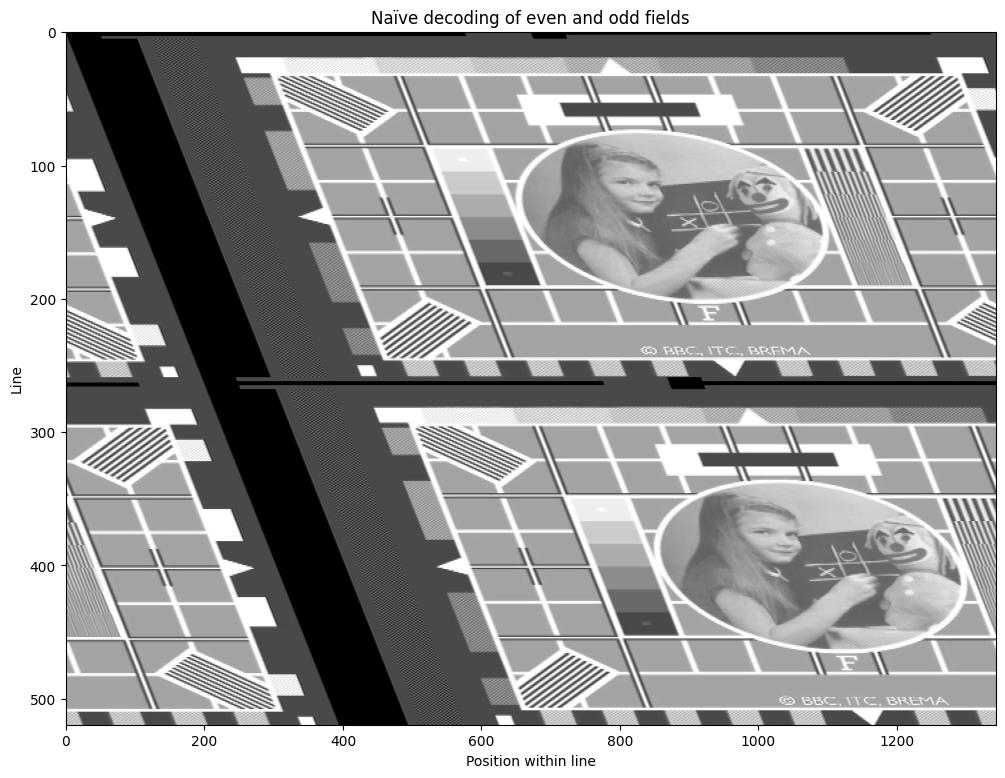

In [160]:
# Show a naïve decoding based entirely on expected line time for both fields.
trimmed_signal = video_signal[line_start_indices[0]:line_start_indices[-1]+1]
line_samples = math.floor(line_time * sample_rate)
n_lines = math.floor(trimmed_signal.shape[0] / line_samples)
naive_decode = trimmed_signal[:n_lines*line_samples].reshape((-1, line_samples))

plt.figure(figsize=(12, 9))
plt.imshow(naive_decode, clim=(sync_level, white_level), cmap=plt.cm.gray, aspect="auto")
plt.title("Naïve decoding of even and odd fields")
plt.xlabel("Position within line")
plt.ylabel("Line")
plt.show()

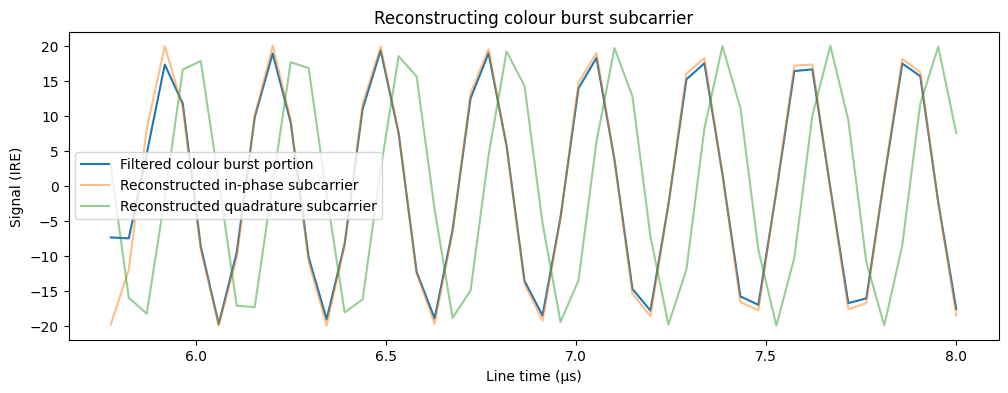

0.4698088306842169


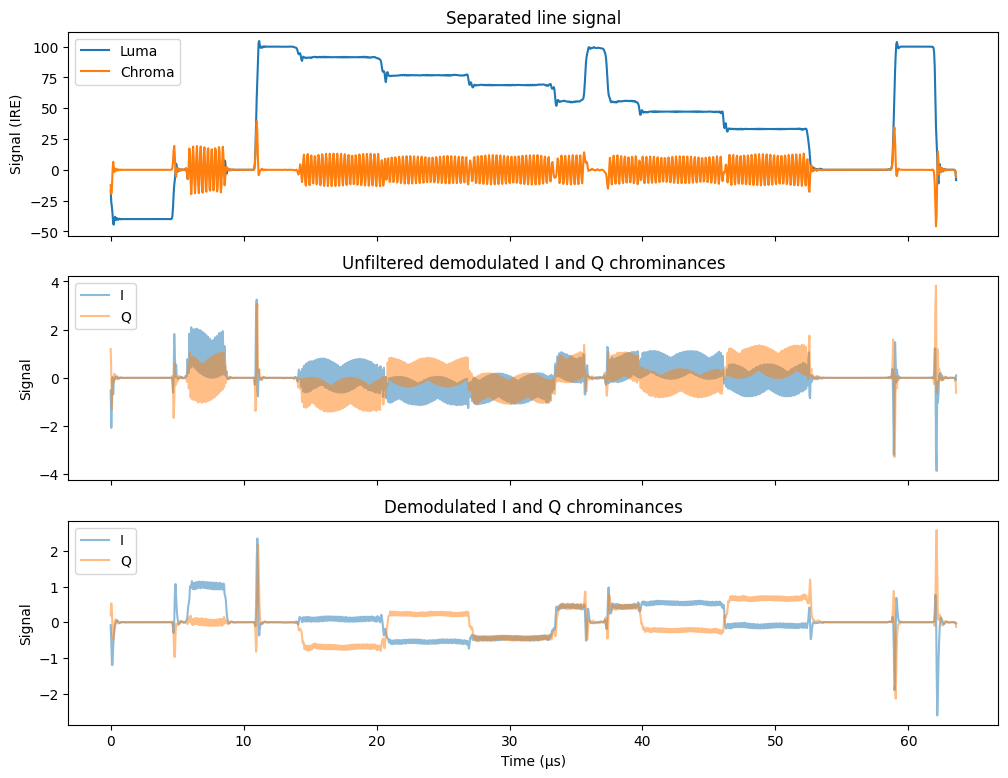

In [161]:
# Show the signal for a single line.
line_number = 25
line_start_idx = line_start_indices[line_number + 4 - 1]
line_sample_count = int(math.ceil(line_time * sample_rate))
line_luma_signal = video_luma_signal[line_start_idx:line_start_idx+line_sample_count]
line_chroma_signal = video_chroma_signal[line_start_idx:line_start_idx+line_sample_count]
line_signal_times = np.arange(line_luma_signal.shape[0]) / sample_rate

# We want to find the "true" frequency of the colourburst. We use a
# technique from https://gist.github.com/endolith/255291/ad8cc6701ec5fa974069a11b0c070631167e3924.

def parabolic(f, x):
    xv = 1/2 * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x
    yv = f[x] - 1/4 * (f[x-1] - f[x+1]) * (xv - x)
    return (xv, yv)

def reconstruct_colourburst_phase(cb_freq, cb_times, cb_samples):
    complex_cb = colour_carrier_amplitude * np.exp(1j * cb_freq * 2 * np.pi * cb_times)
    response = np.sum(cb_samples * complex_cb)
    cb_phase = -np.angle(response)
    return cb_phase

# Extract colour burst from bandpass filtered signal
cb_start_sample = int(math.floor(colour_burst_start_time * sample_rate))
cb_sample_count = int(math.ceil(colour_burst_time * sample_rate))
cb_samples = line_chroma_signal[cb_start_sample:cb_start_sample+cb_sample_count]
cb_times = line_signal_times[cb_start_sample:cb_start_sample+cb_sample_count]

# For the moment we do not attempt to track colourbust frequency.
cb_freq = colour_subcarrier_frequency
cb_phase = reconstruct_colourburst_phase(cb_freq, cb_times, cb_samples)
matched_cb = colour_carrier_amplitude * np.exp(1j * (cb_freq * 2 * np.pi * cb_times + cb_phase))

plt.figure(figsize=(12, 4))
plt.plot(cb_times, cb_samples, label="Filtered colour burst portion")
plt.plot(cb_times, np.real(matched_cb), label="Reconstructed in-phase subcarrier", alpha=0.5)
plt.plot(cb_times, np.imag(matched_cb), label="Reconstructed quadrature subcarrier", alpha=0.5)
plt.xlabel("Line time (µs)")
plt.ylabel("Signal (IRE)")
plt.title("Reconstructing colour burst subcarrier")
plt.legend()
plt.show()

f, (lax, dax, cax) = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
lax.plot(line_signal_times, line_luma_signal, label="Luma")
lax.plot(line_signal_times, line_chroma_signal, label="Chroma")
lax.set_title("Separated line signal")
lax.set_ylabel("Signal (IRE)")
lax.legend()

# Demodulate I and Q components.
cb_subcarrier = np.exp(1j * (cb_freq * 2 * np.pi * line_signal_times + cb_phase))
line_i = np.real(cb_subcarrier) * line_chroma_signal / colour_carrier_amplitude
line_q = np.imag(cb_subcarrier) * line_chroma_signal / colour_carrier_amplitude

# Re-scale colour components based on burst response.
colour_scale = np.mean(line_i[cb_start_sample:cb_start_sample+cb_sample_count])
print(colour_scale)
line_i /= colour_scale
line_q /= colour_scale

dax.plot(line_signal_times, line_i, label="I", alpha=0.5)
dax.plot(line_signal_times, line_q, label="Q", alpha=0.5)
dax.legend()
dax.set_title("Unfiltered demodulated I and Q chrominances")
dax.set_ylabel("Signal")

# Pass demodulation through lowpass filter using nominal chroma burst frequency.
colourburst_low_sos = scipy.signal.butter(
    2, colour_subcarrier_frequency,
    analog=False, btype="lowpass", fs=sample_rate, output="sos"
)
line_i = scipy.signal.sosfilt(colourburst_low_sos, line_i)
line_q = scipy.signal.sosfilt(colourburst_low_sos, line_q)

cax.plot(line_signal_times, line_i, label="I", alpha=0.5)
cax.plot(line_signal_times, line_q, label="Q", alpha=0.5)
cax.legend()
cax.set_title("Demodulated I and Q chrominances")
cax.set_ylabel("Signal")
cax.set_xlabel("Time (µs)")

None

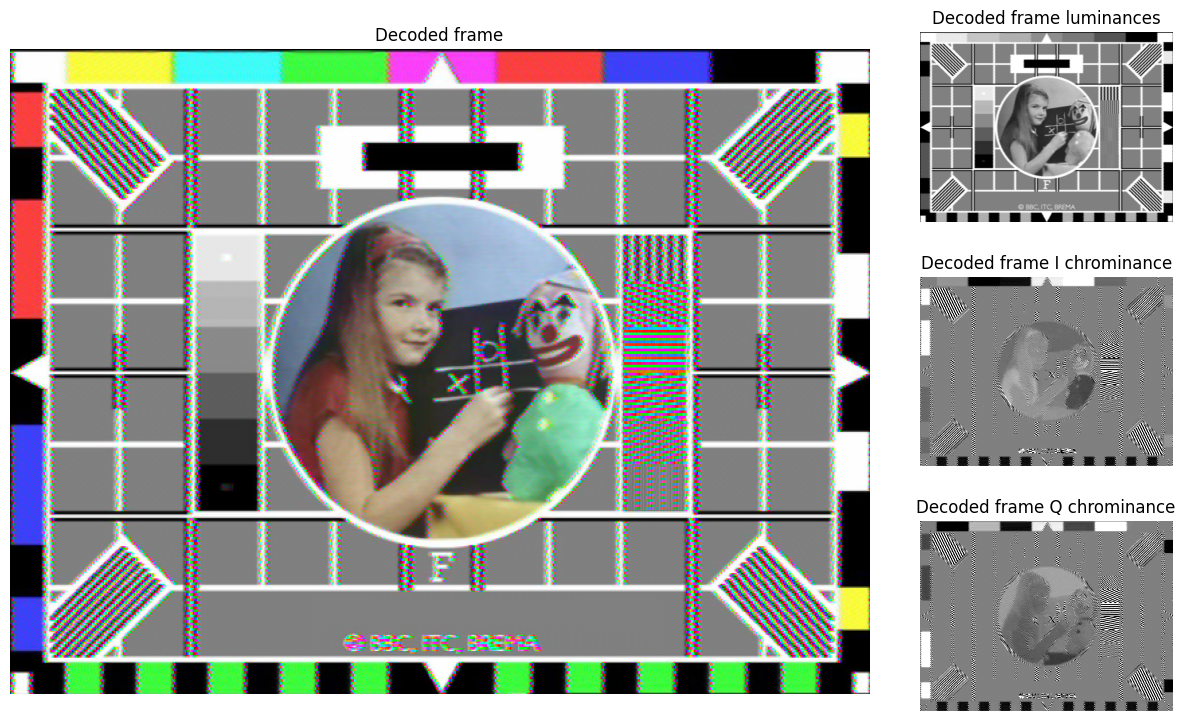

In [162]:
# Number of samples in one line.
line_sample_count = int(math.ceil(line_time * sample_rate))
line_signal_times = np.arange(line_sample_count) / sample_rate

# Compute times within signal of pixels
active_time = line_time - h_sync_time - front_porch_time - back_porch_time
pixel_time = active_time / h_pixel_count
pixel_times = np.arange(h_pixel_count) * pixel_time + h_sync_time + back_porch_time

field_luminances = np.zeros((frame_total_lines, h_pixel_count))
field_is, field_qs = np.zeros_like(field_luminances), np.zeros_like(field_luminances)
for line_idx, line_start_idx in enumerate(line_start_indices):
    line_luma_signal = video_luma_signal[line_start_idx:line_start_idx+line_sample_count]
    line_chroma_signal = video_chroma_signal[line_start_idx:line_start_idx+line_sample_count]
   
    # Extract colour burst from bandpass filtered signal
    cb_start_sample = int(math.floor(colour_burst_start_time * sample_rate))
    cb_sample_count = int(math.ceil(colour_burst_time * sample_rate))
    cb_samples = line_chroma_signal[cb_start_sample:cb_start_sample+cb_sample_count]
    cb_times = line_signal_times[cb_start_sample:cb_start_sample+cb_sample_count]

    # NB: frequency estimation isn't performed.
    cb_freq = colour_subcarrier_frequency
    cb_phase = reconstruct_colourburst_phase(cb_freq, cb_times, cb_samples)

    # Demodulate I and Q components.
    cb_subcarrier = np.exp(1j * (cb_freq * 2 * np.pi * line_signal_times + cb_phase))
    line_i = np.real(cb_subcarrier) * line_chroma_signal / colour_carrier_amplitude
    line_q = np.imag(cb_subcarrier) * line_chroma_signal / colour_carrier_amplitude
    
    # Re-scale based on size of colour burst response (or detect b/w signal)
    colour_scale = np.mean(line_i[cb_start_sample:cb_start_sample+cb_sample_count])
    if colour_scale > 0.2:
        line_i /= colour_scale
        line_q /= colour_scale
    else:
        line_i *= 0
        line_q *= 0

    # Pass demodulation through lowpass filter using nominal chroma burst frequency.
    line_i = scipy.signal.sosfilt(colourburst_low_sos, line_i)
    line_i_interpolator = scipy.interpolate.interp1d(x=line_signal_times, y=line_i, kind="quadratic")
    pixel_is = line_i_interpolator(pixel_times)
    line_q = scipy.signal.sosfilt(colourburst_low_sos, line_q)
    line_q_interpolator = scipy.interpolate.interp1d(x=line_signal_times, y=line_q, kind="quadratic")
    pixel_qs = line_q_interpolator(pixel_times)
    
    # Note we were missing the first 4 lines.
    line_interpolator = scipy.interpolate.interp1d(x=line_signal_times, y=line_luma_signal, kind="quadratic")
    field_luminances[line_idx + 4, :] = line_interpolator(pixel_times)
    field_is[line_idx + 4, :] = np.clip(pixel_is, -1, 1)
    field_qs[line_idx + 4, :] = np.clip(pixel_qs, -1, 1)

# Re-order for frame luminances
frame_luminances = np.zeros_like(field_luminances)
frame_luminances[1::2, :] = field_luminances[:frame_total_lines>>1, :]
frame_luminances[0::2, :] = field_luminances[frame_total_lines>>1:, :]
frame_luminances = (frame_luminances - black_level) / (white_level - black_level)

# Re-order for frame chominance
frame_is = np.zeros_like(field_is)
frame_is[1::2, :] = field_is[:frame_total_lines>>1, :]
frame_is[0::2, :] = field_is[frame_total_lines>>1:, :]
frame_qs = np.zeros_like(field_is)
frame_qs[1::2, :] = field_qs[:frame_total_lines>>1, :]
frame_qs[0::2, :] = field_qs[frame_total_lines>>1:, :]

# Crop to active lines
frame_luminances = frame_luminances[-frame_active_lines:, :]
frame_is = frame_is[-frame_active_lines:, :]
frame_qs = frame_qs[-frame_active_lines:, :]

frame_r = frame_is + frame_luminances
frame_b = frame_qs + frame_luminances
frame_g = (frame_luminances - 0.3 * frame_r - 0.11 * frame_b) / 0.59
frame_colour = np.clip(np.dstack((frame_r, frame_g, frame_b)), 0, 1)

head, _ = os.path.splitext(os.path.basename(input_filename))
output_filename = os.path.join(os.path.dirname(input_filename), f"decoded-{head}.png")
PIL.Image.fromarray((255 * frame_colour).astype(np.uint8), "RGB").save(output_filename)

plt.figure(figsize=(15, 9))

ax = plt.subplot2grid((3, 4), (0, 0), rowspan=3, colspan=3)
ax.set_title("Decoded frame")
ax.imshow(frame_colour)
#ax.imshow(frame_luminances, cmap=plt.cm.gray, clim=(0, 1))
#ax.imshow(frame_is, cmap=plt.cm.gray, clim=(-0.5, 0.5))
ax.set_axis_off()

ax = plt.subplot2grid((3, 4), (0, 3))
ax.set_title("Decoded frame luminances")
ax.imshow(frame_luminances, clim=(0, 1), cmap=plt.cm.gray)
ax.set_axis_off()

ax = plt.subplot2grid((3, 4), (1, 3))
ax.set_title("Decoded frame I chrominance")
ax.imshow(frame_is, clim=(-0.5, 0.5), cmap=plt.cm.gray)
ax.set_axis_off()

ax = plt.subplot2grid((3, 4), (2, 3))
ax.set_title("Decoded frame Q chrominance")
ax.imshow(frame_qs, clim=(-0.5, 0.5), cmap=plt.cm.gray)
ax.set_axis_off()